No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[-0.09116078]
[[0.18232156]]


sample: 100%|██████████| 10500/10500 [00:02<00:00, 3664.04it/s, 1 steps of size 5.72e-01. acc. prob=0.63]


Posterior Mean: [1.9210294 1.940474 ]
Posterior Covariance: [[0.8717318 0.6848434]
 [0.6848434 0.8878377]]


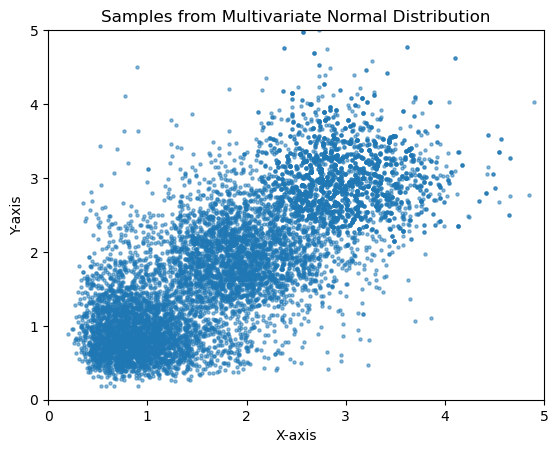

In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dists
import numpy as np

# Set up the random number generator
rng_key = jax.random.PRNGKey(0)

# Define the mean vector and covariance matrix for the multivariate normal distribution
mu1 = np.array([1.0, 1.0])
cov1 = np.array([[0.2, 0], [0, 0.2]])

mu2 = np.array([2.0, 2.0])
cov2 = np.array([[0.2, 0], [0, 0.2]])

mu3 = np.array([3.0, 3.0])
cov3 = np.array([[0.2, 0], [0, 0.2]])

# Number of samples
num_samples = 10000


def get_alpha(mu, cov):
    alpha = np.zeros(len(mu))
    for i in range(len(mu)):
        alpha[i] = np.log(mu[i]) - 1/2*np.log(cov[i,i]/mu[i]**2 +1)
    return np.array(alpha)

def get_beta(mu, cov):
    beta = np.zeros((len(mu), len(mu)))
    for i in range(len(mu)):
        for j in range(len(mu)):
            beta[i,j] = np.log(cov[i,j]/(mu[i]*mu[j])+1)
    return beta

print(get_alpha(np.array([1]), np.array([[0.2]])))
print(get_beta(np.array([1]), np.array([[0.2]])))



# Create a NumPyro model for the multivariate normal distribution
def multivariate_normal_model():
    # Sample from a multivariate normal distribution
    multinorm1 = dists.MultivariateNormal(loc=get_alpha(mu1, cov1), covariance_matrix=get_beta(mu1,cov1))
    dist1 = dists.TransformedDistribution(multinorm1, dists.transforms.ExpTransform())
    multinorm2 = dists.MultivariateNormal(loc=get_alpha(mu2, cov2), covariance_matrix=get_beta(mu2,cov2))
    dist2 = dists.TransformedDistribution(multinorm2, dists.transforms.ExpTransform())
    multinorm3 = dists.MultivariateNormal(loc=get_alpha(mu3, cov3), covariance_matrix=get_beta(mu3,cov1))
    dist3 = dists.TransformedDistribution(multinorm3, dists.transforms.ExpTransform())

    mixing_dist = dists.Categorical(probs=jnp.ones(3) / 3)

    final_dist = dists.MixtureGeneral(mixing_dist, [dist1,dist2,dist3])


    sample = numpyro.sample("sample", final_dist)
    return sample

# Use NumPyro's MCMC to sample from the multivariate normal distribution
mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(multivariate_normal_model),
    num_warmup=500,
    num_samples=num_samples,
    num_chains=1  # For simplicity, we use a single chain
)

# Run the MCMC
mcmc.run(rng_key)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Print the mean and covariance of the posterior samples
print("Posterior Mean:", jnp.mean(posterior_samples["sample"], axis=0))
print("Posterior Covariance:", jnp.cov(posterior_samples["sample"], rowvar=False))

# Visualize the samples (scatter plot)
import matplotlib.pyplot as plt
plt.scatter(posterior_samples["sample"][:, 0], posterior_samples["sample"][:, 1], alpha=0.5, s=5)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim([0,5])
plt.ylim([0,5])

plt.title("Samples from Multivariate Normal Distribution")
plt.show()


In [2]:
a = jnp.array([0,1,2])
a

Array([0, 1, 2], dtype=int32)